# Exercises 7: Empirical Risk Minimization #

In [67]:
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
import pandas as pd

## 1. Unfalsifiable Model ##

In [68]:
tseries = np.loadtxt('data.txt')

t = np.array(tseries[0,:], dtype = 'complex')
y = np.array(tseries[1,:], dtype = 'complex')

a) Plot the signal

C:\Users\klees\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


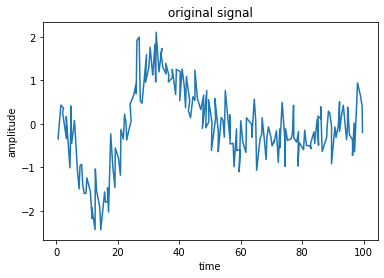

In [69]:
plt.plot(t, y)
plt.xlabel('time')
plt.ylabel('amplitude')
_ = plt.title('original signal')

(b) Find the Fourier coefficients that describe the signal and reconstruct the signal from its Fourier
coefficients (FFT won’t work since the time points are not equally sampled, use the Riemann sum
approximation of the continuous Fourier integral prepared in FT.py).

In [70]:
def FourierRiemann(y,t):
    T=np.max(t)

    omega=np.array(2*np.pi/T*np.arange(t.shape[0]),dtype='complex')
    a=np.zeros_like(omega)
    for na in range(omega.shape[0]):
        w=omega[na]
        a[na] = np.sum(np.exp(-1j*w*t)*y)/np.sqrt(y.shape[0])
    return a

a=FourierRiemann(y,t)

def IFourierRiemann(a,t):
    T=np.max(t)
    omega=np.array(2*np.pi/T*np.arange(a.shape[0]),dtype='complex')
    
    yre=np.zeros_like(t)    
    na=0
    for lt in t:
        yre[na]=np.sum(np.exp(1j*omega*lt)*a)/np.sqrt(a.shape[0])
        na +=1
    
    return yre

yre=IFourierRiemann(a,t)

(c) Plot the original and the Fourier-reconstructed signal on top of each other to show that they
match very well.

C:\Users\klees\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\klees\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


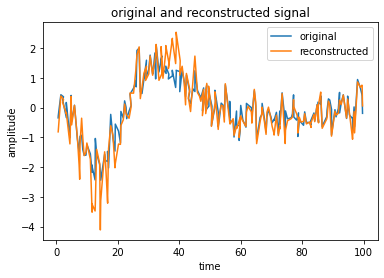

In [71]:
plt.plot(t, y, label = 'original')
plt.plot(t, yre, label = 'reconstructed')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.title('original and reconstructed signal')
_ = plt.legend()

(d) Take 100 random downsamples of the data, each containing a fraction f of of the data points
and construct the Fourier coefficients in the same way as in b,c. Compute the training error (L2
loss) and the test error from the prediction of the remaining 1 − f data points (given the Fourier
coefficients obtained from the training sample). Use f = 0.5, 0.75, 0.9, 0.95.

In [72]:
f = [0.5, 0.75, 0.9, 0.95]
N = 100

training_errors = np.zeros((N, len(f)))
testing_errors = np.zeros((N, len(f)))

for i in range(len(f)):
    for j in range(N):
        # split data
        t_train, t_test, y_train, y_test = train_test_split(t, y, test_size=1-f[i])
        
        # fourier transform
        a = FourierRiemann(y_train, t_train)
        yre_train = IFourierRiemann(a, t_train)
        yre_test = IFourierRiemann(a, t_test)
        
        # mse
        mse_train = mean_squared_error(np.real(y_train), np.real(yre_train))
        mse_test = mean_squared_error(np.real(y_test), np.real(yre_test))
        
        training_errors[j, i] = mse_train
        testing_errors[j, i] = mse_test

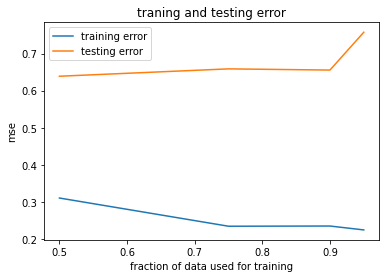

In [73]:
# plot training and testing error
training_error = np.mean(training_errors, axis = 0)
testing_error = np.mean(testing_errors, axis = 0)

plt.plot(f, training_error, label='training error')
plt.plot(f, testing_error, label='testing error')
plt.xlabel('fraction of data used for training')
plt.ylabel('mse')
plt.title('traning and testing error')
_ = plt.legend()

(e) What makes the model unfalsifiable?

With more data taking into account for training, the training error decreases but the testing error increases. The two errors therefore do not converge and we have an unfalsifiable model.

## 2. Polynomial SRM ##

(a) Write a function that fits the timeseries with a polynomial of order 8 using statsmodels.regression.linear model.OLS.

In [32]:
def fit_poly_regression(t, y, order):
    X_df = compute_data_matrix(t, order)
    
    model = sm.OLS(y, X_df)
    results = model.fit()
    
    return X_df, model, results

def compute_data_matrix(t, order):
    X = np.ones((len(t), 1))
    columns = ['t0']
    
    for i in range(1, order+1):
        X = np.hstack((X, (t ** i).reshape(-1, 1)))
        columns.append('t{}'.format(i))
    X_df = pd.DataFrame(X, columns = columns)
    return X_df

In [64]:
t = np.real(t)
y = np.real(y)

X_df, model, results = fit_poly_regression(t, y, 8)

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     99.63
Date:                Thu, 07 Jul 2022   Prob (F-statistic):           2.17e-56
Time:                        09:59:56   Log-Likelihood:                -117.02
No. Observations:                 200   AIC:                             248.0
Df Residuals:                     193   BIC:                             271.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
t0            -0.0015   8.09e-05    -18.309      0.000      -0.002      -0.001
t1            -0.0113      0.001    -18.313      0.000      -0.013      -0.010
t2            -0.0564      0.003    -18.326      0.000      -0.062      -0.050
t3             0.0063      0.000     16.585      0.000       0.006       0.007
t4            -0.0003   1.82e-05    -14.669      0.000      -0.000      -0.000
t5          5.695e-06    4.4e-07     12.952      0.000    4.83e-06    6.56e-06
t6         -6.547e-08   5.69e-09    -11.504      0.000   -7.67e-08   -5.42e-08
t7          3.882e-10   3.77e-11     10.305      0.000    3.14e-10    4.62e-10
t8          -9.33e-13      1e-13     -9.311      0.000   -1.13e-12   -7.35e-13
==============================================================================
Omnibus:                        3.605   Durbin-Watson:                   1.735
Prob(Omnibus):                  0.165   Jarque-Bera (JB):                3.341
Skew:                           0.314   Prob(JB):                        0.188
Kurtosis:                       3.086   Cond. No.                     3.08e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.08e+16. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

(b) Compute the training error (L2 loss) as a function of the polynomial order. Explain your result.

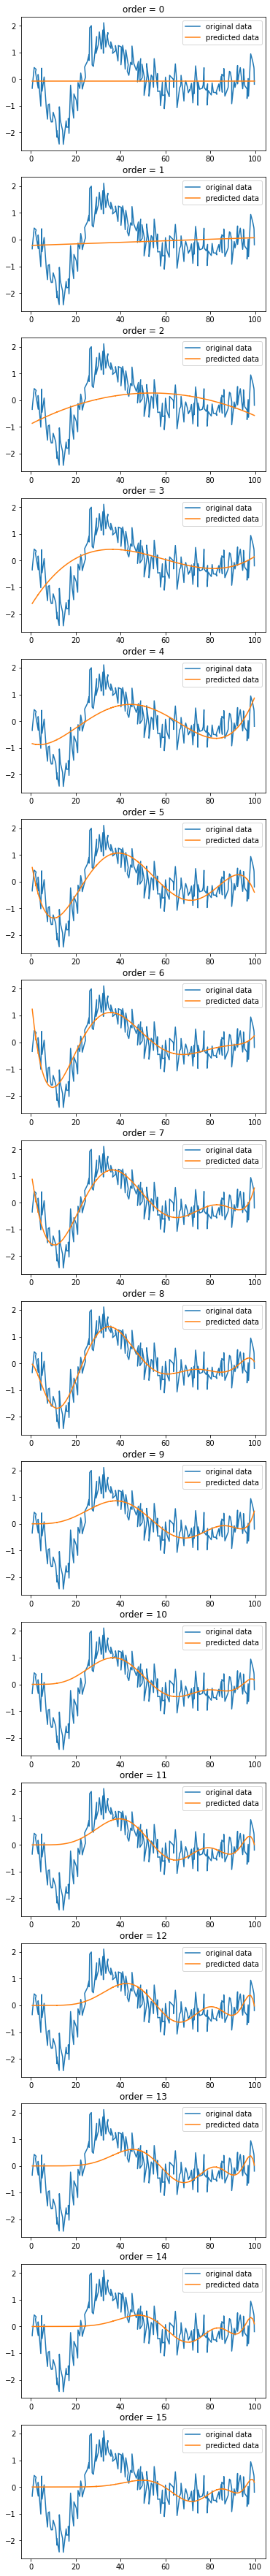

In [34]:
orders = np.arange(0, 15+1)

training_errors = np.zeros(len(orders))
fig, ax = plt.subplots(len(orders), figsize=(6, len(orders)*4))

for i in orders:
    X_df, model, results = fit_poly_regression(t, y, i)
    y_pred = X_df @ results.params
    training_errors[i] = mean_squared_error(y, y_pred)
    ax[i].plot(t, y, label = 'original data')
    ax[i].plot(t, y_pred, label = 'predicted data')
    ax[i].legend()
    ax[i].set_title('order = {}'.format(i))

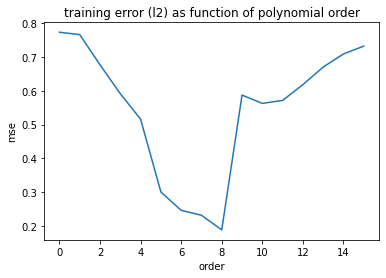

In [36]:
plt.plot(orders, training_errors)
plt.xlabel('order')
plt.ylabel('mse')
_ = plt.title('training error (l2) as function of polynomial order')

The training error decreases with increasing polynomial order because more and more variability in the data is explained due to higher order polynomials.

(c) Take 100 random downsamples of the data, each containing a fraction f of of the data points
and fit the model. Compute the training error and the test error from the prediction of the
remaining 1 − f data points (given the model parameters obtained from the training sample). Use
f = 0.5, 0.75, 0.9, 0.95.

In [58]:
f = [0.5, 0.75, 0.9, 0.95]
N = 100
orders = np.arange(0, 15+1)

training_errors = np.zeros((N, len(f), len(orders)))
testing_errors = np.zeros((N, len(f), len(orders)))

for i in range(len(f)):
    for j in orders:
        for k in range(N):
        
            # split data
            t_train, t_test, y_train, y_test = train_test_split(t, y, test_size=1-f[i])

            # fit model
            X_df_train, model, results = fit_poly_regression(t_train, y_train, j)
            X_df_test = compute_data_matrix(t_test, j)
            
            y_pred_train = X_df_train @ results.params
            y_pred_test = X_df_test @ results.params
            
            # mse
            mse_train = mean_squared_error(y_train, y_pred_train)
            mse_test = mean_squared_error(y_test, y_pred_test)
            
            training_errors[k, i, j] = mse_train
            testing_errors[k, i, j] = mse_test
            
mean_training_errors = np.mean(training_errors, axis = 0)
mean_testing_errors = np.mean(testing_errors, axis = 0)

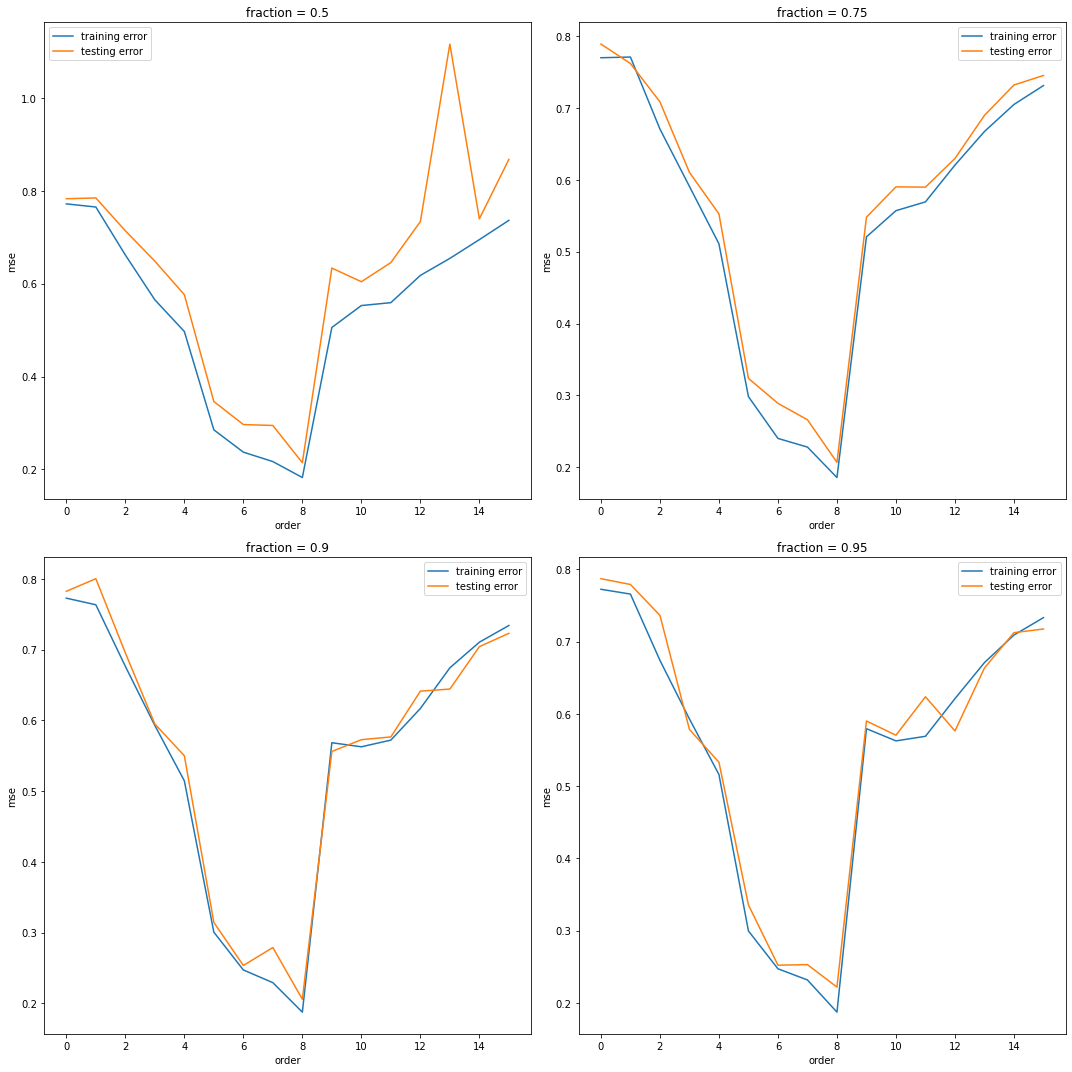

In [63]:
fig, ax = plt.subplots(len(f)//2, len(f)//2, figsize=(15,15))
ax = ax.reshape(-1,1)

for i in range(len(f)):
    ax[i][0].plot(orders, mean_training_errors[i, :], label ='training error')
    ax[i][0].plot(orders, mean_testing_errors[i, :], label ='testing error')
    ax[i][0].legend()
    ax[i][0].set_xlabel('order')
    ax[i][0].set_ylabel('mse')
    ax[i][0].set_title('fraction = {}'.format(f[i]))
plt.tight_layout()

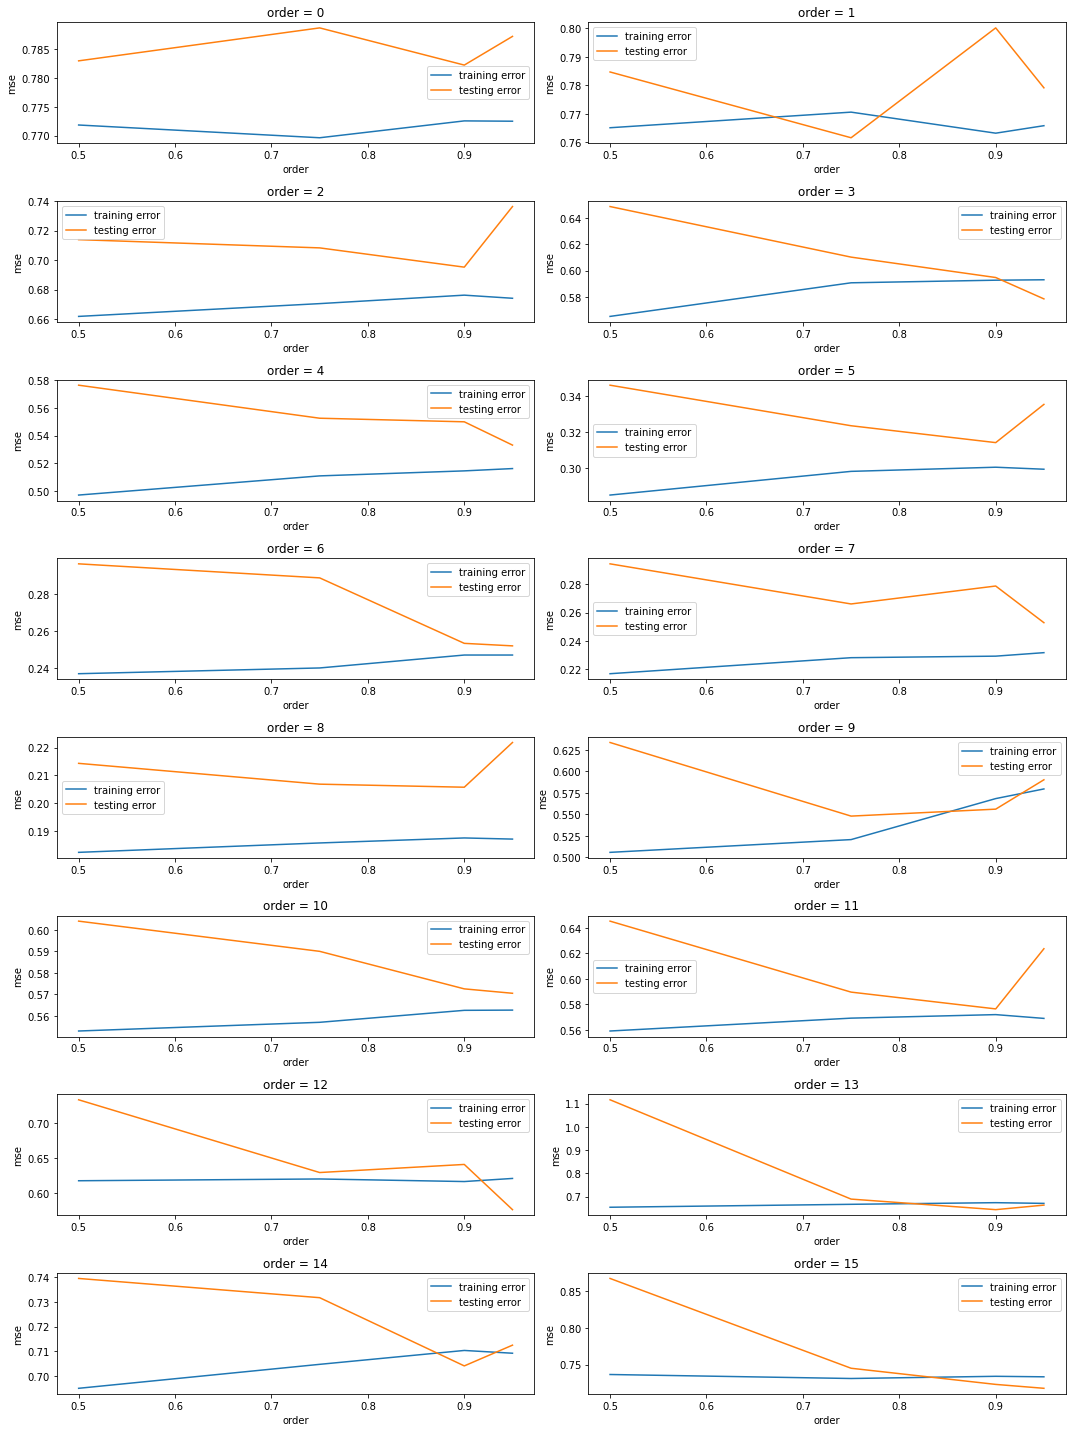

In [62]:
fig, ax = plt.subplots(len(orders)//2, 2, figsize=(15,20))
ax = ax.reshape(-1,1)

for j in range(len(orders)):
    ax[j][0].plot(f, mean_training_errors[:, j], label ='training error')
    ax[j][0].plot(f, mean_testing_errors[:, j], label ='testing error')
    ax[j][0].legend()
    ax[j][0].set_xlabel('order')
    ax[j][0].set_ylabel('mse')
    ax[j][0].set_title('order = {}'.format(orders[j]))
plt.tight_layout()

Training and testing error now converge.

(d) What is the optimal model complexity?

The optimal model complexity is order 8.

## 3. Capacity ##

(a) Write a function that generates 200 random data points in N dimensions, where N is a function
argument and randomly assign binary labels to the data points.

In [14]:
def random_data(n_points, n_dim):
    
    X = np.random.uniform(size=(n_points, n_dim))
    y = np.random.randint(2, size=n_points)
    
    return X, y

(b) Use logistic regression (sklearn.linear model.LogisticRegression) to seperate the data points
for increasing N > 2, 3, .... and monitor the error rate as a function of N .)

In [15]:
n_points = 200
n_dim = 200
dimensions = np.arange(1, n_dim+1)

error_rates = np.zeros(n_dim)

for i in dimensions:
    X, y = random_data(n_points, i)

    clf = LogisticRegression(random_state=0).fit(X, y)
    error_rates[i-1] = 1 - clf.score(X, y)

C:\Users\klees\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\klees\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

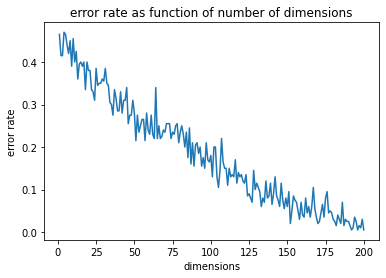

In [16]:
plt.plot(dimensions, error_rates)
plt.xlabel('dimensions')
plt.ylabel('error rate')
_ = plt.title('error rate as function of number of dimensions')

For constant number of patterns, with increasing dimensions, data can be separated better and better.